# Goal
Use the CV by Earthquake ID strategy to train on all segments except the left out earthquake.  Then compare the predicted and actual values to visualize where this simple model is making the most mistakes. The majority of this code is derived from [aperezhortal/cv-splitting-by-earthquake-id](https://www.kaggle.com/aperezhortal/cv-splitting-by-earthquake-id)


In [17]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut

from catboost import CatBoostRegressor

## Load the data

In [4]:
%timeit
train_df = pd.read_csv('../../input/train.csv', 
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
chunksize = 150000

segments = int(np.floor(train_df.shape[0] / chunksize))

In [5]:
print("Number of records:\t{}".format(len(train_df)))
print("Number of segments:\t{}".format(segments))
print("Records per segment:\t{}".format(chunksize))

Number of records:	629145480
Number of segments:	4194
Records per segment:	150000


## Feature generator

In [6]:
sampling_frequency = 4e6 #4mhz
sampling_period = 1./sampling_frequency

def generate_features(segment_signal):
    
    segment_signal = segment_signal - segment_signal.mean()
    
    features = pd.Series()
    
    windows = 10
    signal_roll_std = segment_signal.rolling(windows).std().dropna().values
    features['std_roll_std_10'] = signal_roll_std.std()
    features['mean_roll_std_10'] = signal_roll_std.mean()
    features['q05_roll_std_10'] = np.percentile(signal_roll_std, 0.05)
    features['min_roll_std_10'] = signal_roll_std.min()
    features['q95_roll_std_10'] = np.percentile(signal_roll_std, 0.95)           
    
    return features

def get_model():
    model = CatBoostRegressor(iterations=2000, 
                              loss_function='MAE', 
                              boosting_type='Plain')
    fit_kwargs = dict(silent=True)    
    return model, fit_kwargs    

In [7]:
x_train = pd.DataFrame()
quake_ids = pd.Series()
y_train = pd.Series()

current_quake_id = 0
last_time_to_failure = train_df.iloc[0]['time_to_failure']

for segment_number in tqdm(range(segments)):
    
    segment_df = train_df.iloc[segment_number*chunksize:
                               segment_number*chunksize+chunksize]
    
    times_to_failure = segment_df['time_to_failure'].values
    
    # Ignore segments with an earthquake in it.
    if np.abs(times_to_failure[0]-times_to_failure[-1])>1:
        continue
    
    y_train.loc[segment_number] = times_to_failure[-1]
    
    features = generate_features(segment_df['acoustic_data'])
    x_train=x_train.append(features, ignore_index=True)    
        
    if np.abs(times_to_failure[-1]-last_time_to_failure)>1:
        current_quake_id += 1
    
    quake_ids.loc[segment_number] = current_quake_id
    last_time_to_failure = times_to_failure[-1]

del train_df

100%|██████████| 4194/4194 [01:07<00:00, 62.14it/s]


# Create segment_df and quake_df
1. Create `segment_df`: 
    - All of the features
    - `quake_id`
    - `y_train`
    - `validation_segment_pred`, 
2. Create `quake_df` with features from segment_df

In [8]:
segment_df = x_train.copy()
segment_df['quake_id'] = quake_ids
segment_df['y_train'] = y_train

In [88]:
quake_gb = segment_df.groupby('quake_id')

quake_summary = {}
for quake_id, quake in quake_gb:
    time_min = quake['y_train'].min()
    time_max = quake['y_train'].max()
    quake_duration = time_max-time_min
    num_segments = len(quake)
    segment_idxes = quake.index
    quake_summary[int(quake_id)] = [quake_id, time_min, time_max, quake_duration, num_segments, segment_idxes]

quake_df = pd.DataFrame(quake_summary).T
quake_df.columns = ['quake_id', 'time_min','time_max','quake_duration','num_segments','segment_idxes']

In [89]:
quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.4908,11.455,295,"Int64Index([ 38, 39, 40, 41, 42, 43, 44,..."
2,2,0.0337959,14.1381,14.1043,363,"Int64Index([334, 335, 336, 337, 338, 339, 340,..."
3,3,0.00639766,8.812,8.8056,227,"Int64Index([698, 699, 700, 701, 702, 703, 704,..."
4,4,0.0367983,12.6227,12.5859,324,"Int64Index([ 926, 927, 928, 929, 930, 931..."
5,5,0.0276957,8.0151,7.9874,206,"Int64Index([1251, 1252, 1253, 1254, 1255, 1256..."
6,6,0.0334984,7.008,6.9745,180,"Int64Index([1458, 1459, 1460, 1461, 1462, 1463..."
7,7,0.0102978,16.0638,16.0535,413,"Int64Index([1639, 1640, 1641, 1642, 1643, 1644..."
8,8,0.00649738,7.8386,7.8321,202,"Int64Index([2053, 2054, 2055, 2056, 2057, 2058..."
9,9,0.0206955,9.5669,9.5462,246,"Int64Index([2256, 2257, 2258, 2259, 2260, 2261..."


# Residuals

In [91]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

### CV validation strategy


Following the discussions in https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/78809 we will use the LeaveOneGroupOut validation strategy.
- Use one earthquake for validation
- Use the rest for training

In [92]:
segment_df['validation_segment_pred'] = np.NaN
segment_df.head(10)

,mean_roll_std_10,min_roll_std_10,q05_roll_std_10,q95_roll_std_10,std_roll_std_10,quake_id,y_train,validation_segment_pred,validation_segment_residual
0,3.507118,0.421637,0.875595,1.264911,2.809071,0.0,1.430797,NaN,3.621702
1,3.761435,0.421637,0.849804,1.269296,4.120785,0.0,1.391499,NaN,2.541707
2,4.080841,0.516398,0.875595,1.286684,4.227960,0.0,1.353196,NaN,1.520838
3,3.788192,0.516398,0.875466,1.264911,4.284176,0.0,1.313798,NaN,3.409736
4,3.835604,0.516398,0.843174,1.264911,4.183253,0.0,1.274400,NaN,3.287983
5,3.619584,0.674949,0.918937,1.286684,3.145920,0.0,1.236097,NaN,1.473152
6,3.793559,0.483046,0.875595,1.286684,3.335217,0.0,1.196798,NaN,1.481845
7,3.569382,0.471405,0.843274,1.264911,3.603515,0.0,1.158496,NaN,3.990304
8,4.281486,0.483046,0.875595,1.316561,5.220409,0.0,1.119097,NaN,1.044430
9,3.990454,0.483046,0.875595,1.286684,4.203261,0.0,1.079699,NaN,1.808281


In [93]:
group_kfold = LeaveOneGroupOut()
fold_splitter = group_kfold.split(x_train, y_train, quake_ids)

train_errors = list()
validation_errors = list()
for group_out, (train_index, valid_index) in enumerate(fold_splitter):
    if group_out in [16]:
        continue
        
    print('Validation Earthquake:', group_out,end="   ")
    
    train_signal, validation_signal = x_train.iloc[train_index], x_train.iloc[valid_index]
    train_quaketime, validation_quaketime = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_signal = scaler.transform(train_signal)
    validation_signal = scaler.transform(validation_signal)    
            
    selected_model , fit_kwargs = get_model()
    selected_model.fit(train_signal, train_quaketime, **fit_kwargs)
    
    train_error = mean_absolute_error(selected_model.predict(train_signal), train_quaketime)

    #     validation_error = mean_absolute_error(selected_model.predict(validation_signal), validation_quaketime)
    validation_segment_pred = selected_model.predict(validation_signal)
    segment_df.loc[valid_index,'validation_segment_pred'] = validation_segment_pred
    
    validation_error = mean_absolute_error(validation_segment_pred, validation_quaketime)

    print('train_error: {0:.2f} \t validation_error: {1:.2f} '.format(train_error, validation_error))
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)
    
mean_train_error = np.asarray(train_errors).mean()
mean_validation_error = np.asarray(validation_errors).mean()

print("\nMean train_error: {0:.2f}".format(mean_train_error))
print("Mean validation_errors: {0:.2f}".format(mean_validation_error))

Validation Earthquake: 0   train_error: 1.93 	 validation_error: 3.07 
Validation Earthquake: 1   train_error: 1.97 	 validation_error: 1.72 
Validation Earthquake: 2   train_error: 1.86 	 validation_error: 2.96 
Validation Earthquake: 3   train_error: 1.98 	 validation_error: 1.29 
Validation Earthquake: 4   train_error: 1.93 	 validation_error: 2.24 
Validation Earthquake: 5   train_error: 1.93 	 validation_error: 2.26 
Validation Earthquake: 6   train_error: 1.93 	 validation_error: 2.26 
Validation Earthquake: 7   train_error: 1.74 	 validation_error: 3.95 
Validation Earthquake: 8   train_error: 1.91 	 validation_error: 2.58 
Validation Earthquake: 9   train_error: 2.00 	 validation_error: 1.09 
Validation Earthquake: 10   train_error: 1.99 	 validation_error: 1.58 
Validation Earthquake: 11   train_error: 1.99 	 validation_error: 1.40 
Validation Earthquake: 12   train_error: 1.98 	 validation_error: 1.42 
Validation Earthquake: 13   train_error: 1.95 	 validation_error: 1.78 
Va

In [94]:
segment_df['validation_segment_residual'] = segment_df['validation_segment_pred'] - segment_df['y_train']

# Skipped the last quake_id
train_errors.append(np.NaN)
quake_df['train_error'] = train_errors
validation_errors.append(np.NaN)
quake_df['validation_errors'] = validation_errors

In [95]:
quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_errors
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",1.932713,3.072957
1,1,0.0357963,11.4908,11.455,295,"Int64Index([ 38, 39, 40, 41, 42, 43, 44,...",1.974419,1.722768
2,2,0.0337959,14.1381,14.1043,363,"Int64Index([334, 335, 336, 337, 338, 339, 340,...",1.864055,2.962261
3,3,0.00639766,8.812,8.8056,227,"Int64Index([698, 699, 700, 701, 702, 703, 704,...",1.978853,1.294465
4,4,0.0367983,12.6227,12.5859,324,"Int64Index([ 926, 927, 928, 929, 930, 931...",1.934713,2.241763
5,5,0.0276957,8.0151,7.9874,206,"Int64Index([1251, 1252, 1253, 1254, 1255, 1256...",1.927386,2.255150
6,6,0.0334984,7.008,6.9745,180,"Int64Index([1458, 1459, 1460, 1461, 1462, 1463...",1.932377,2.260419
7,7,0.0102978,16.0638,16.0535,413,"Int64Index([1639, 1640, 1641, 1642, 1643, 1644...",1.743013,3.952492
8,8,0.00649738,7.8386,7.8321,202,"Int64Index([2053, 2054, 2055, 2056, 2057, 2058...",1.913091,2.575057
9,9,0.0206955,9.5669,9.5462,246,"Int64Index([2256, 2257, 2258, 2259, 2260, 2261...",1.999144,1.086749


# Actual TTF

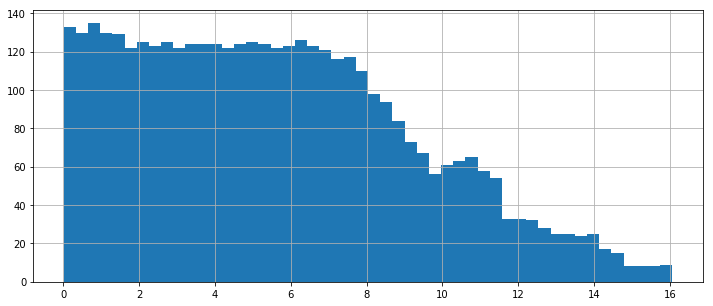

In [96]:
ax1 = segment_df['y_train'].hist(bins=50, figsize=(12,5))

# Predicted TTF

(-0.7964723099023104, 16.866666964069008)

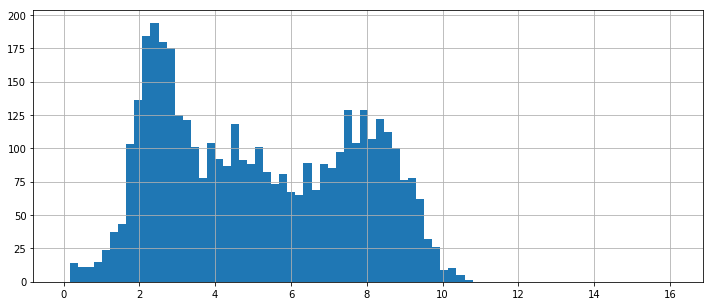

In [97]:
ax2 = segment_df['validation_segment_pred'].hist(bins=50, figsize=(12,5))
# Use the same xlim as ax1
ax2.set_xlim(ax1.set_xlim())

In [142]:
def plot_segment_residual(segment_df, target='y_train', set_ax2_ylim=True):
    fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
    ax1.plot(segment_df[target])
    ax1.set_ylabel(target)
    ax1.set_xlabel("Segment #")

    ax2 = ax1.twinx() 
    ax2.plot( segment_df['validation_segment_pred'], color='r')
    ax2.set_ylabel('y_pred')
    
    # Force y_pred to use the same ylim as target
    if set_ax2_ylim:

        ax2.set_ylim(ax1.set_ylim())
    plt.show()

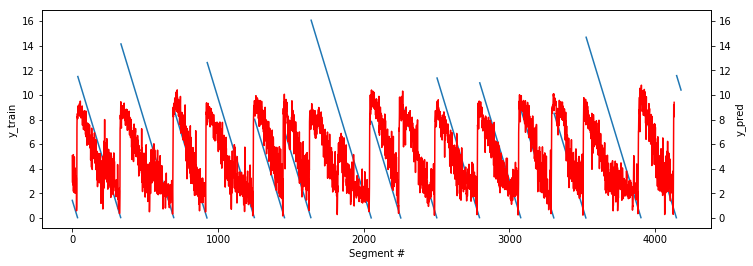

In [144]:
plot_segment_residual(segment_df, set_ax2_ylim=True)

The longest earthquakes have 'fake_quake's roughly halfway through.

# Zoom in on a SubSegment

Use `segment_idxes` field of quake_df to select the a specific quake, or any contiguous time period

In [133]:
quake_df.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_errors
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",1.932713,3.072957
1,1,0.0357963,11.4908,11.455,295,"Int64Index([ 38, 39, 40, 41, 42, 43, 44,...",1.974419,1.722768
2,2,0.0337959,14.1381,14.1043,363,"Int64Index([334, 335, 336, 337, 338, 339, 340,...",1.864055,2.962261
3,3,0.00639766,8.812,8.8056,227,"Int64Index([698, 699, 700, 701, 702, 703, 704,...",1.978853,1.294465
4,4,0.0367983,12.6227,12.5859,324,"Int64Index([ 926, 927, 928, 929, 930, 931...",1.934713,2.241763


In [134]:
quake_num = 8
quake_df.loc[quake_num,'segment_idxes']

Int64Index([2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
            ...
            2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254],
           dtype='int64', length=202)

In [135]:
sub_segment = segment_df.iloc[quake_df.loc[quake_num,'segment_idxes']]
sub_segment.head()

,mean_roll_std_10,min_roll_std_10,q05_roll_std_10,q95_roll_std_10,std_roll_std_10,quake_id,y_train,validation_segment_pred,validation_segment_residual,y_train_cut
2053,2.739581,0.421637,0.816497,1.173788,1.662191,8.0,7.838597,10.398090,2.559494,"(5.359, 8.035]"
2054,3.296907,0.483046,0.816358,1.197219,5.747152,8.0,7.799198,9.124554,1.325356,"(5.359, 8.035]"
2055,2.842652,0.421637,0.843274,1.197219,1.985161,8.0,7.760896,9.001199,1.240304,"(5.359, 8.035]"
2056,2.924820,0.421637,0.823273,1.197219,2.317581,8.0,7.721597,9.479339,1.757742,"(5.359, 8.035]"
2057,2.817246,0.527046,0.823273,1.173788,1.928767,8.0,7.682199,9.645909,1.963710,"(5.359, 8.035]"


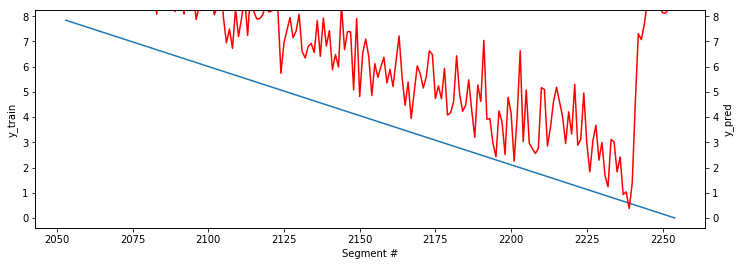

In [148]:
plot_segment_residual(sub_segment, set_ax2_ylim=True)

## Inspecting Residuals by Binning the Actual Values

Turn 'y_train' into a categorical bin, 'y_train_cut'.  Plot each bin's predicted values and residuals

In [149]:
def binned_residuals(segment_df, num_cuts=6, num_bins=50):
    segment_df['y_train_cut'] = pd.cut(segment_df['y_train'], bins=num_cuts)
    print(segment_df['y_train_cut'].value_counts())
    
    segment_df[['y_train_cut','y_train','validation_segment_pred']].hist(by='y_train_cut',bins=num_bins, figsize=(12,6))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

(-0.00966, 2.683]    1068
(2.683, 5.359]       1030
(5.359, 8.035]       1001
(8.035, 10.711]       618
(10.711, 13.388]      322
(13.388, 16.064]      123
Name: y_train_cut, dtype: int64


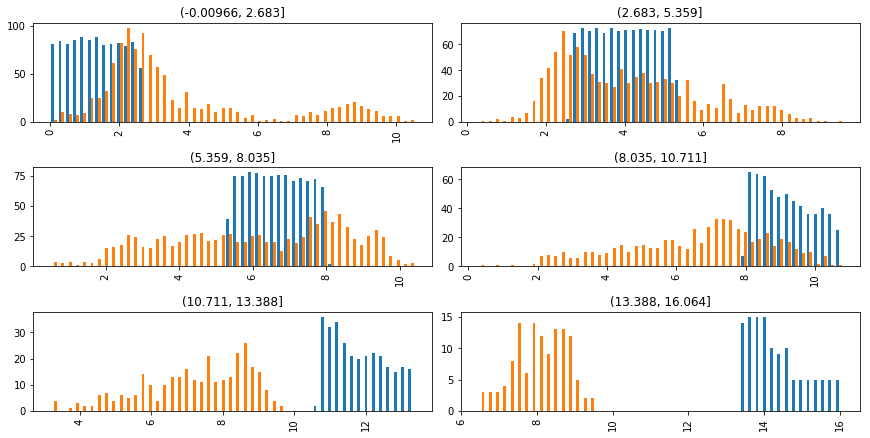

In [150]:
binned_residuals(segment_df)

(6.533, 7.839]       34
(3.923, 5.228]       34
(2.617, 3.923]       34
(-0.00133, 1.312]    34
(5.228, 6.533]       33
(1.312, 2.617]       33
Name: y_train_cut, dtype: int64


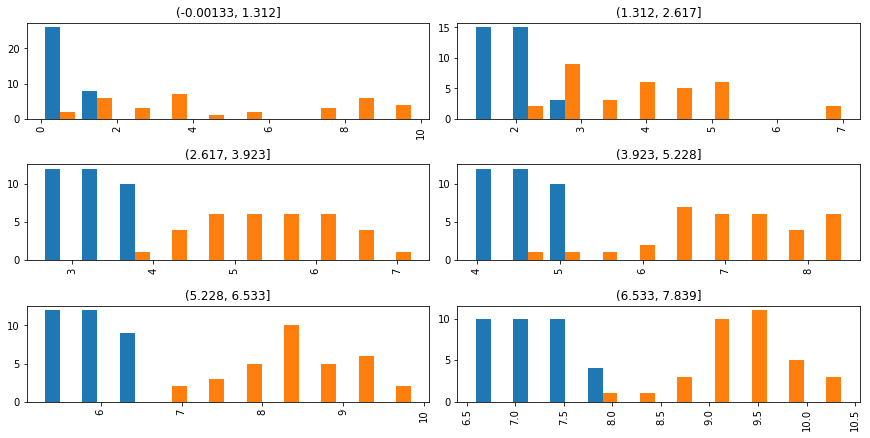

In [151]:
binned_residuals(sub_segment, num_bins=10)

In [155]:
import seaborn as sns

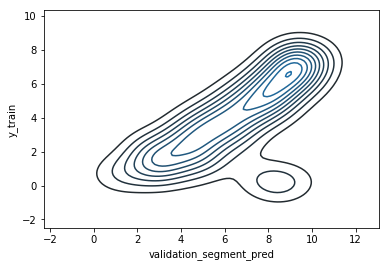

In [168]:
ax1 = sns.kdeplot(sub_segment['validation_segment_pred'], sub_segment['y_train'])

The errors for this subsegment become obvious when drawing a kernel density plot.  The 'fake_quake's are causing segments with actual TTF values ('y_train') in the (0 - 2) range to become predicted in the 8-10 range.

All of the quakes have this pattern, even quakes with the lowest validation error

In [176]:
quake_df.sort_values('validation_errors')

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_errors
9,9,0.0206955,9.5669,9.5462,246,"Int64Index([2256, 2257, 2258, 2259, 2260, 2261...",1.999144,1.086749
3,3,0.00639766,8.812,8.8056,227,"Int64Index([698, 699, 700, 701, 702, 703, 704,...",1.978853,1.294465
11,11,0.0287966,10.9773,10.9485,282,"Int64Index([2796, 2797, 2798, 2799, 2800, 2801...",1.994330,1.402241
15,15,0.0218996,9.4127,9.3908,242,"Int64Index([3904, 3905, 3906, 3907, 3908, 3909...",1.972702,1.415591
12,12,0.0128967,8.7802,8.7673,226,"Int64Index([3079, 3080, 3081, 3082, 3083, 3084...",1.977484,1.423604
10,10,0.0310956,11.369,11.3379,292,"Int64Index([2503, 2504, 2505, 2506, 2507, 2508...",1.986615,1.581578
1,1,0.0357963,11.4908,11.455,295,"Int64Index([ 38, 39, 40, 41, 42, 43, 44,...",1.974419,1.722768
13,13,0.0072983,8.5022,8.4949,219,"Int64Index([3306, 3307, 3308, 3309, 3310, 3311...",1.950834,1.778408
4,4,0.0367983,12.6227,12.5859,324,"Int64Index([ 926, 927, 928, 929, 930, 931...",1.934713,2.241763
5,5,0.0276957,8.0151,7.9874,206,"Int64Index([1251, 1252, 1253, 1254, 1255, 1256...",1.927386,2.255150


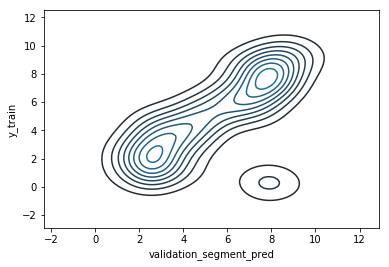

In [177]:
quake_num = 9

sub_segment = segment_df.iloc[quake_df.loc[quake_num,'segment_idxes']]
sns.kdeplot(sub_segment['validation_segment_pred'], sub_segment['y_train'])

## View Residuals for All Training Data

The boundaries and number of bin cuts can change, but we would ideally want the residuals to be centered around 0. The errors may not be normally distributed as they should be in a model that makes linear assumptions.

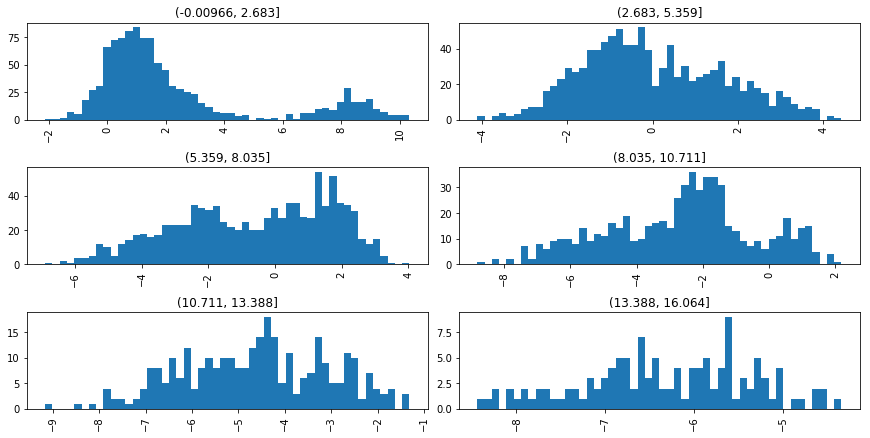

In [152]:
num_cuts = 6
segment_df['y_train_cut'] = pd.cut(segment_df['y_train'], bins=num_cuts)
segment_df[['y_train_cut','validation_segment_residual']].hist(by='y_train_cut',bins=50, figsize=(12,6))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

A model that underestimates the top range, but overestimates the low range is a reasonable strategy for minimizing the Absolute Error.  

# Feature Correlations with Target

The feature correlation with target will tell us how far away the next earthquake is. It would be useful to find a feature that us how confident we are that the earthquake would occur at that time, and how wide the confidence interval is.

## Univariate Feature Correlations with Target


In [153]:
# num_features = 3
# top_correlations = x_train.corrwith(y_train).sort_values().head(num_features).index

## q95_roll_std_10

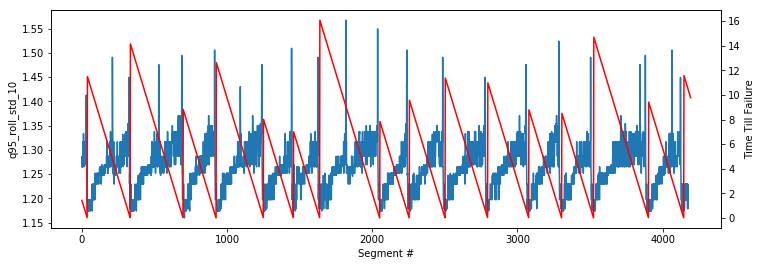

In [68]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(x_train['q95_roll_std_10'])
ax1.set_ylabel("q95_roll_std_10")
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( y_train, color='r')
ax2.set_ylabel('Time Till Failure')
plt.show()

q95_roll_std_10 has a noticeable trend that is inversely proportional to the TTF

## q05_roll_std_10

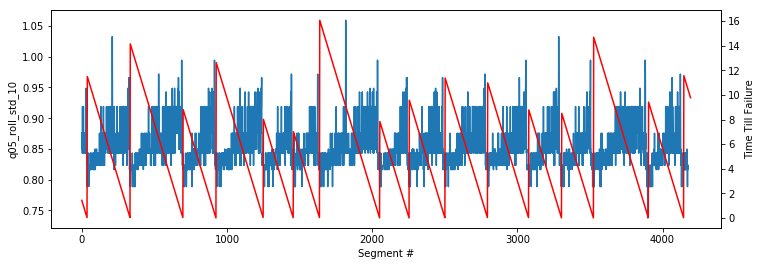

In [70]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(x_train['q05_roll_std_10'])
ax1.set_ylabel("q05_roll_std_10")
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( y_train, color='r')
ax2.set_ylabel('Time Till Failure')
plt.show()

## mean_roll_std_10

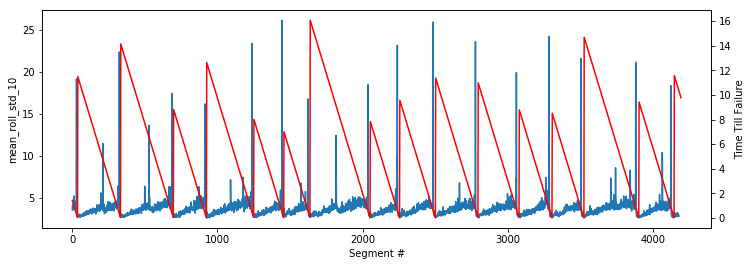

In [71]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(x_train['mean_roll_std_10'])
ax1.set_ylabel("mean_roll_std_10")
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( y_train, color='r')
ax2.set_ylabel('Time Till Failure')
plt.show()

# Results

I've used an oversimplified model and the results may not be replicated in our leading models.  Reruning this should be as easy as changing the get_model() function.

There are two types of errors that we are seeing:

1. Errors that are the result of cyclical occurences (i.e. 'fake quake's)
2. Errors that are the result of drift